In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
from scipy.stats import linregress as lin
from scipy.optimize import curve_fit
from datetime import datetime, timedelta

from netCDF4 import Dataset

In [6]:
N = np.size(glob.glob("./JPL_mscn*.csv", recursive=True))
M = np.shape(np.genfromtxt('JPL_mscn017.csv', delimiter=',', skip_header=15))[0]

In [30]:
#glob.glob("./JPL_mscn*.csv", recursive=True)

In [7]:
file_n = sorted(glob.glob("./JPL_mscn*.csv", recursive=True))

data = np.empty((N, M, 2))
for i, fn in enumerate(file_n):
    file = np.genfromtxt(fn, delimiter=',', skip_header=15)
    #print(file.shape,i)
    data[i] = file

In [9]:
# Detrend
trends = np.zeros((N, 7))
def fit_f(t, a0, a1, a2, a3, a4, b0, b1):
    lintr = a0 + a1 * t + a2 * t * t
    seasonal = a3 * np.cos(2.0 * np.pi / 365.25 * t + b0)
    halfyear = a4 * np.cos(4.0 * np.pi / 365.25 * t + b1)
    return lintr + seasonal + halfyear

for i in range(N):
    popt, pcov = curve_fit(fit_f, data[i,:,0], data[i,:,1])
    trends[i] = popt

def detrend(data, t, trend):
    return data - trend[0] - trend[1] * t - trend[2] * t ** 2 - trend[3] * np.cos(2.0 * np.pi / 365.25 * t + trend[5]) - trend[4] * np.cos(4.0 * np.pi / 365.25 * t + trend[6])
    
ddata = np.empty((N, M))
for i in range(N):
    ddata[i] = detrend(data[i,:,1], data[i,:,0], trends[i])
    
    


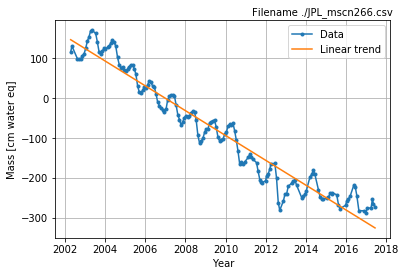

In [10]:
data_num = -1

xlist = 2002 + data[data_num-1][:,0]/365.25
tims = np.array([datetime(2002, 1, 1) + timedelta(days=int(t)) for t in data[data_num-1][:,0]])
ylist = data[data_num-1][:,1]

trend = lin(xlist,ylist)

f, ax = plt.subplots()
ax.plot(xlist,ylist,'.-',label = 'Data')
ax.plot(xlist,xlist * trend[0] + trend[1],label = 'Linear trend')
ax.set_xlabel('Year')
ax.set_ylabel('Mass [cm water eq]')
plt.legend()
ax.grid()
ax.text(0.58, 0.9, "Filename %s" % (file_n[data_num-1]), transform=f.transFigure)
f.savefig("./Pictures2/timeseries_cm_266", dpi=300)
plt.show()

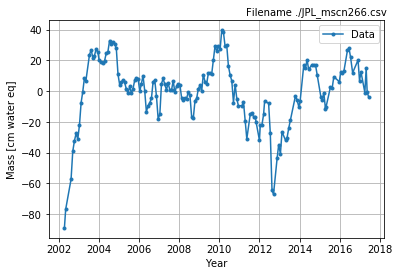

In [11]:
data_num = -1

xlist = 2002 + data[data_num-1][:,0]/365.25
tims = np.array([datetime(2002, 1, 1) + timedelta(days=int(t)) for t in data[data_num-1][:,0]])
ylist = data[data_num-1][:,1]

detrended = detrend(ylist, data[data_num-1][:,0], trends[data_num-1])

f, ax = plt.subplots()
ax.plot(xlist,detrended,'.-',label = 'Data')
ax.set_xlabel('Year')
ax.set_ylabel('Mass [cm water eq]')
plt.legend()
ax.grid()
ax.text(0.58, 0.9, "Filename %s" % (file_n[data_num-1]), transform=f.transFigure)
f.savefig("./Pictures2/timeseries_cm_266", dpi=300)
plt.show()

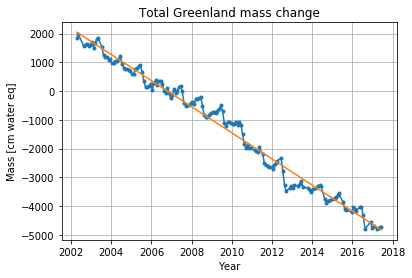

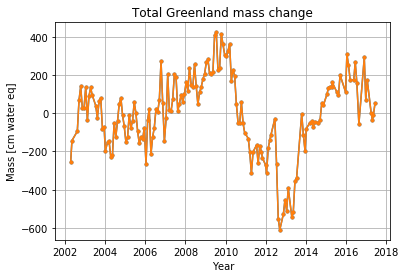

In [12]:
xlist = 2002 + data[0][:,0]/365.25
ylist = np.sum(data, axis = 0)[:,1]

total_trend = curve_fit(fit_f, data[0,:,0], ylist)[0]
total_detrended = detrend(ylist, data[0][:,0], total_trend)
trend = lin(xlist, ylist)

plt.plot(xlist,ylist,'.-',label = 'Data')
plt.plot(xlist,xlist * trend[0] + trend[1],label = 'Linear trend')
plt.title('Total Greenland mass change')
plt.xlabel('Year')
plt.ylabel('Mass [cm water eq]')
plt.grid()
plt.savefig("./Pictures2/timeseries_total_cm", dpi=300)
plt.show()

plt.plot(xlist,ddata.sum(axis=0),'.-',label = 'Components Detrended')
plt.plot(xlist, total_detrended,'.-',label = 'Total Detrended')

plt.title('Total Greenland mass change')
plt.xlabel('Year')
plt.ylabel('Mass [cm water eq]')
plt.grid()
plt.savefig("./Pictures2/timeseries_detrended_total_cm", dpi=300)
plt.show()

In [13]:
vel_av = total_trend[1]
acc_av = total_trend[2]
total_time = data[0][-1,0] - data[0][0,0]
print('The average speed is ' + str(np.round(vel_av,decimals=2)) + ' Gt/day.')
print('The average acceleration is ' + str(np.round(acc_av,decimals=6)) + ' Gt/day^2.')
print('The fraction of acceration of the velocity over the total time period is ' + str(np.round(100*acc_av/vel_av*total_time, decimals = 1)) + '%.')

The average speed is -1.08 Gt/day.
The average acceleration is -3e-05 Gt/day^2.
The fraction of acceration of the velocity over the total time period is 15.6%.


In [14]:
vel_av*365
acc_av*365*365

-4.041669081704468

In [15]:
#F = data[:,:,1].T
F = ddata.T
FT = np.copy(F.T)
for i in range(FT.shape[0]):
    FT[i] -= FT[i].mean()
F = np.copy(FT.T)
C = np.dot(FT, F)
evals, evecs = np.linalg.eig(C)
PCA = np.dot(F, evecs[:])

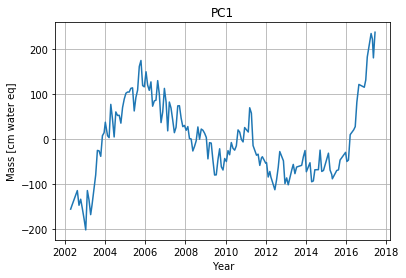

In [17]:
PCA_num = 1

plt.plot(xlist, PCA[:,PCA_num-1])
plt.xlabel('Year')
plt.ylabel('Mass [cm water eq]')
plt.title('PC' + str(PCA_num))
plt.grid()
plt.savefig("./Pictures2/PC%i" %PCA_num, dpi=300)
plt.show()

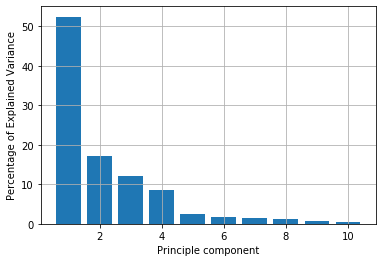

In [18]:
pca_max = 10
bars = evals / evals.sum()*100
plt.bar(x=range(1,pca_max+1), height=bars[:pca_max])
plt.xlabel('Principle component')
plt.ylabel('Percentage of Explained Variance')
plt.grid()
plt.savefig("./Pictures2/PC_explained_cm", dpi=300)
plt.show()

In [19]:
R_earth = 6371*10**3
A_earth = 4*np.pi*R_earth**2
N_c = 4551
teta = np.arange(-87,90,3)
teta = 2*np.pi/360*teta

In [20]:
def dellam(teta):
    return(4*np.pi/(np.cos(teta)*N_c* 3/360*2*np.pi))

In [22]:
lamda = np.zeros((teta.size, int(2.0 * np.pi // dellam(0))))
for i in range(teta.size):
    for j in range(lamda.shape[1]):
        lamda[i,j] = (j) * dellam(teta[i])
        if lamda[i,j] >= 2*np.pi:
            lamda[i,j] = np.nan

In [16]:
#lon = np.zeros(lamda.shape)
#for i in range(lamda.shape[0]):
#    lon[i,:] = 360/(2*np.pi)*lamda[i,:]*2*np.pi/np.nanmax(lamda[i])

#lat = 360/(2*np.pi)*teta+1.5
#lon = 360/(2*np.pi)*lamda

In [17]:
#siz = np.size(lamda[27,:])-np.isnan(lamda[27,:]).sum()
#((siz-1)/siz * 360/(2*np.pi)*lamda[27,:]*2*np.pi/np.nanmax(lamda[27]))

In [23]:
# testcell
lon = np.zeros(lamda.shape)
for i in range(lamda.shape[0]):
    if 2*np.pi-np.max(lamda[i,:]) < 0.5*lamda[i,1]:
        lon[i,:] = 360/(2*np.pi)*lamda[i,:]*2*np.pi/np.nanmax(lamda[i])
    else:
        siz = np.size(lamda[i,:])-np.isnan(lamda[i,:]).sum()
        lon[i,:] = (siz-1)/siz * 360/(2*np.pi)*lamda[i,:]*2*np.pi/np.nanmax(lamda[i])
        if siz < np.size(lamda[i,:]):
            lon[i,siz] = 360

lat = 360/(2*np.pi)*teta-1.5
#lon = 360/(2*np.pi)*lamda

In [26]:
sdata = data[:,:,1]

In [24]:
def rebin_data(data, lats, irr_lons, true_color=True):
    rl_sz = irr_lons[0].size
    new_sz = 721
    lonspace = np.linspace(0,360,new_sz)
    fit = np.zeros((lat.size, new_sz))
    mask = np.full((lat.size, new_sz), False)
    rlons = None
    
    for k in range(irr_lons.shape[0]):
        sz = np.sum(np.logical_not(np.isnan(irr_lons[k])))
        al = np.zeros(rl_sz)
        ml = np.full(rl_sz, True)
        rlons = irr_lons[k] if sz == irr_lons[k].size else rlons
        if k == 1:
            al[sz-3] = data[0] if true_color else 0.0
            al[sz-2] = data[1] if true_color else 1.0

            ml[sz-3] = False
            ml[sz-2] = False
        if k == 2:
            al[sz-5] = data[2] if true_color else 1.0
            al[sz-4] = data[3] if true_color else 0.0
            al[sz-3] = data[4] if true_color else 1.0
            al[sz-2] = data[5] if true_color else 0.0

            ml[sz-5] = False
            ml[sz-4] = False
            ml[sz-3] = False
            ml[sz-2] = False
        if k == 3:
            al[sz-6] = data[6] if true_color else 0.0
            al[sz-5] = data[7] if true_color else 1.0
            al[sz-4] = data[8] if true_color else 0.0
            al[sz-3] = data[9] if true_color else 1.0

            ml[sz-6] = False
            ml[sz-5] = False
            ml[sz-4] = False
            ml[sz-3] = False
        if k == 4:
            al[sz-7] = data[10] if true_color else 1.0
            al[sz-6] = data[11] if true_color else 0.0
            al[sz-5] = data[12] if true_color else 1.0
            al[sz-4] = data[13] if true_color else 0.0
            al[sz-3] = data[14] if true_color else 1.0

            ml[sz-7] = False
            ml[sz-6] = False
            ml[sz-5] = False
            ml[sz-4] = False
            ml[sz-3] = False
        if k == 5:
            al[sz-7] = data[15] if true_color else 1.0
            al[sz-6] = data[16] if true_color else 0.0
            al[sz-5] = data[17] if true_color else 1.0
            al[sz-4] = data[18] if true_color else 0.0

            ml[sz-7] = False
            ml[sz-6] = False
            ml[sz-5] = False
            ml[sz-4] = False
        if k == 6:
            al[sz-8] = data[19] if true_color else 0.0
            al[sz-7] = data[20] if true_color else 1.0
            al[sz-6] = data[21] if true_color else 0.0
            al[sz-5] = data[22] if true_color else 1.0
            al[sz-4] = data[23] if true_color else 0.0

            ml[sz-8] = False
            ml[sz-7] = False
            ml[sz-6] = False
            ml[sz-5] = False
            ml[sz-4] = False
        if k == 7:
            al[sz-9] = data[24] if true_color else 1.0
            al[sz-8] = data[25] if true_color else 0.0
            al[sz-7] = data[26] if true_color else 1.0
            al[sz-6] = data[27] if true_color else 0.0

            ml[sz-9] = False
            ml[sz-8] = False
            ml[sz-7] = False
            ml[sz-6] = False
        if k == 8:
            al[sz-9] = data[28] if true_color else 1.0
            al[sz-8] = data[29] if true_color else 0.0

            ml[sz-9] = False
            ml[sz-8] = False
        if k == 9:
            al[sz-9] = data[30] if true_color else 0.0
            ml[sz-9] = False
        #fit = np.zeros(lon[29].size)
        j = 0
        for i in range(fit.shape[1]):
            if lonspace[i] > irr_lons[k,j+1] and not np.isnan(irr_lons[k,j+1]):
                j = min(j+1, irr_lons[k].size - 2)
            fit[k,i] = al[j]
            mask[k,i] = ml[j]
        fit[k,-1] = fit[k,0]
        mask[k,-1] = mask[k,0]
    assert(rlons is not None)
    XV, YV = np.meshgrid(lonspace, -lats)
    return XV, YV, np.ma.array(fit, mask=mask)


year = 2009.5
time = np.argmin(np.abs(xlist - year))

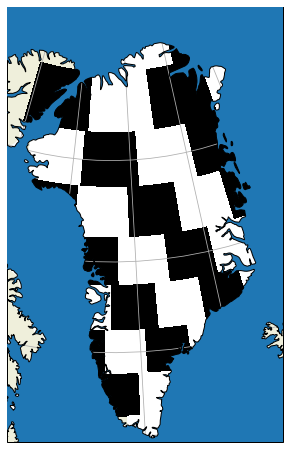

In [27]:
# Dummy Map
XV, YV, dumdata = rebin_data(sdata[:,0], lat, lon, False)
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)


f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
cb = ax.pcolor(XV, YV, dumdata, cmap=plt.cm.binary, vmin = 0.0, vmax = 1.0, transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
#f.savefig("./Pictures2/dummy_map.png", dpi=300)
plt.show()

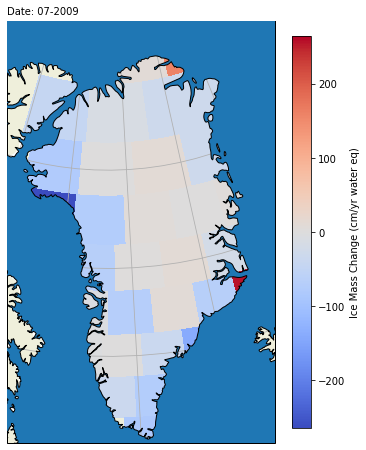

In [28]:
# Verbeterde Plot Routine
XV, YV, fit = rebin_data(sdata[:,time], lat, lon)
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)
#proj = ccrs.PlateCarree(central_longitude=310)


f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
cb = ax.pcolor(XV, YV, fit, cmap=plt.cm.coolwarm, vmin = -np.max(np.abs(fit)), vmax = np.max(np.abs(fit)), transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
ax.text(0.125, 0.88, "Date: %s" % tims[time].strftime("%m-%Y"), transform=f.transFigure)
cax = f.colorbar(cb, ax=[ax], shrink=0.9)
cax.set_label("Ice Mass Change (cm/yr water eq)")
f.savefig("./Pictures2/data_%s.png" % tims[time].strftime("%m_%Y"), dpi=300)
plt.show()

In [29]:
eof_i = 1
XV, YV, eof_fit = rebin_data(evecs[:,eof_i-1], lat, lon)

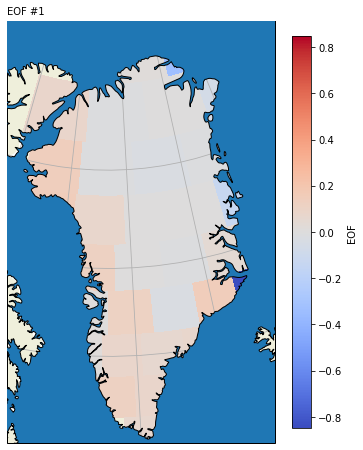

In [30]:
# Verbeterde Plot Routine
proj = ccrs.LambertConformal(central_latitude=90, central_longitude=310)

f, ax = plt.subplots(figsize=(6, 8), subplot_kw=dict(projection=proj))
cb = ax.pcolor(XV, YV, eof_fit, cmap=plt.cm.coolwarm, vmin = -np.max(np.abs(eof_fit)), vmax = np.max(np.abs(eof_fit)), transform=ccrs.PlateCarree())
ax.set_extent([-65, -25, 59, 85], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m'), zorder=100, edgecolor='k')
ax.gridlines()
ax.text(0.125, 0.88, "EOF #%i" % eof_i, transform=f.transFigure)
cax = f.colorbar(cb, ax=[ax], shrink=0.9)
cax.set_label("EOF")
f.savefig("./Pictures2/EOF%i_cm.png" % eof_i, dpi=300)
plt.show()

# New

In [35]:
mask = Dataset("./Icemask_Topo_Iceclasses_lon_lat_average_1km.nc", mode='r')
mlon = mask['LON'][:] + 180.
mlat = mask['LAT'][:]
mask.close()

lonc = lon[:,:-1] + (lon[:,1:] - lon[:,:-1]) / 2.0
latc = np.array([np.full(lonc.shape[1], l) for l in lat])

In [ ]:
ICE = np.zeros(lat.size * lonc.shape[1])
create_file = True

if create_file:
    data = Dataset("./smb_rec.2002-2017.BN_RACMO2.3p2_FGRN055_GrIS.MM.nc", mode='r')
    T = data['time'][:]
    for ti in range(T.size):
        for yi in range(mlat.shape[0]):
            dslice = data['SMB_rec'][ti,yi,:]
            for xi, val in enumerate(dslice):
                L = np.sqrt((mlon[yi,xi] - lonc) ** 2 + (mlat[yi,xi] - latc) ** 2)
                Li = np.nanargmin(L)
                ICE[Li] += val
            print(yi + 1, dslice.shape[0])
    ICE = ICE.reshape((lat.size, lonc.shape[1]))
    data.close()
    
    data = Dataset("./ICE_mascon.nc", mode='w')
    data.createDimension('time', None)
    data.createDimension('lat', ICE.shape[0])
    data.createDimension('lon', ICE.shape[1])

    data.createVariable("time", ("time",))
    data.createVariable("SMB", ("time", "lat", "lon"))

    data['time'][:] = T
    data['SMB'][:] = ICE

    data.close()
else:
    data = Dataset("./ICE_mascon.nc", mode='r')
    T = data['time'][:]
    ICE = data['SMB'][:]
    data.close()

1 1496
2 1496
3 1496
4 1496
5 1496
6 1496
7 1496
8 1496
9 1496
10 1496
11 1496
12 1496
13 1496
14 1496
15 1496
16 1496
17 1496
18 1496
19 1496
20 1496
21 1496
22 1496
23 1496
24 1496
25 1496
26 1496
27 1496
28 1496
29 1496
30 1496
31 1496
32 1496
33 1496
34 1496
35 1496
36 1496
37 1496
38 1496
39 1496
40 1496
41 1496
42 1496
43 1496
44 1496
45 1496
46 1496
47 1496
48 1496
49 1496
50 1496
51 1496
52 1496
53 1496
54 1496
55 1496
56 1496
57 1496
58 1496
59 1496
60 1496
61 1496
62 1496
63 1496
64 1496
65 1496
66 1496
67 1496
68 1496
69 1496
70 1496
71 1496
72 1496
73 1496
74 1496
75 1496
76 1496
77 1496
78 1496
79 1496
80 1496
81 1496
82 1496
83 1496
84 1496
85 1496
86 1496
87 1496
88 1496
89 1496
90 1496


In [4]:
np.argmin([[1,2], [0,3]])

2

In [36]:
ICE = np.zeros((lat.size, lonc.shape[1]))

ICE.shape

(59, 118)

In [33]:
data.close()